In [2]:
using LogicCircuits

In [3]:
function FindRightmostVarVtree(vt)
    stopping = false
    rightmost = -1
    v = vt
    while !stopping
        v = v.right
        if typeof(v) == PlainVtreeLeafNode
            stopping = true
            rightmost = v.var
        end
    end
    return rightmost
end

FindRightmostVarVtree (generic function with 1 method)

The rightmost variable is 13


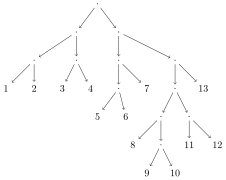

In [4]:
vtree = PlainVtree(13, :random)
println("The rightmost variable is ",FindRightmostVarVtree(vtree))
plot(vtree)

In [5]:
function l_revision(sdd,vtree)
    VERBOSE = false
    rightmost = FindRightmostVarVtree(vtree)
    println("-",rightmost[1])
    circuit = PlainLogicCircuit(sdd)
    root = circuit
    current = circuit
    parent = circuit
    visited = Any[]
    parents = Any[]
    stopping = false
    while !stopping
        if typeof(current) == Plain⋁Node
            for i = 1:length(current.children)
                if !(current.children[i] in visited)
                    push!(parents,current)
                    current = current.children[i]
                    push!(visited,current)
                    break
                end
                if i == length(current.children)
                    if current == root
                        stopping = true
                    end
                    for i = 1:length(visited)
                        if current == visited[i]
                            current = parents[i]
                            break
                        end
                    end
                end 
            end
        elseif typeof(current) == Plain⋀Node
            if !(current.children[1] in visited)
                push!(parents,current)
                current = current.children[1]
                push!(visited,current)
            elseif !(current.children[2] in visited)
                push!(parents,current)
                current = current.children[2]
                push!(visited,current)
            else
                for i = 1:length(visited)
                    if current == visited[i]
                        current = parents[i]
                        break
                    end
                end
            end
        else 
            if typeof(current) == PlainLiteralNode
                VERBOSE && println("L",current.literal)
                if abs(current.literal) == rightmost
                    piece = PlainLogicCircuit(-current.literal)
                    circuit = replace_node(circuit,current,piece)
                end
            elseif typeof(current) == PlainTrueNode
                VERBOSE && println("T")
            elseif typeof(current) == PlainFalseNode
                VERBOSE && println("F")    
            end
            for i = 1:length(visited)
                if current == visited[i]
                    current = parents[i]
                    break
                end
            end
        end
    end
    return circuit
end

l_revision (generic function with 1 method)

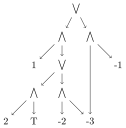

In [6]:
sun, rain, rainbow = pos_literals(LogicCircuit, 3)
formula = (rainbow & sun & rain) | (-rainbow); # rainbow implies sun and rain
vtree = PlainVtree(3, :balanced)
#:rightlinear, :leftlinear, :random, :balanced
manager = SddMgr(vtree)
sdd = compile(manager, formula);
plot(sdd)

-3


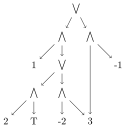

In [7]:
plot(l_revision(sdd,vtree))

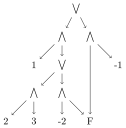

In [8]:
sun, rain, rainbow = pos_literals(LogicCircuit, 3)
formula1 = (rainbow & sun & rain) # | (-rainbow); # rainbow implies sun and rain
formula2 = (-rainbow & -sun & rain) # | (rainbow); # rainbow implies sun and rain
vtree = PlainVtree(3, :balanced)
#:rightlinear, :leftlinear, :random, :balanced
manager = SddMgr(vtree)
sdd1 = compile(manager, formula1);
sdd2 = compile(manager, formula2);
plot(sdd1)

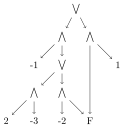

In [9]:
plot(sdd2)

In [10]:
sdd3 = conjoin(sdd1,sdd2)
plot(sdd3)

In [11]:
"""
Conjoin two SDDs
"""
@inline conjoin(x::SddConstantNode, y::SddConstantNode) = 
    ((x === false_sdd) || (y === false_sdd)) ? false_sdd : true_sdd  
@inline conjoin(x::Sdd, y::SddConstantNode) = 
    (y === false_sdd) ? false_sdd : x
@inline conjoin(x::SddConstantNode, y::Sdd) = 
    conjoin(y, x)

# const stats = Dict{Tuple{Int,Int},Int}()

"""
    conjoin(s::SddLiteralNode, t::SddLiteralNode)::Sdd
Conjoin SDD Literal Nodes.
"""
function conjoin(s::SddLiteralNode, t::SddLiteralNode)::Sdd 
    if mgr(s) === mgr(t)
        (s === t) ? s : false_sdd
    else
        conjoin_indep(s,t)
    end
end

# Note: attempts to make a special cache for conjunctions with literals have not yielded speedups

"""
    function conjoin(s::Sdd, t::Sdd)::Sdd
Conjoins two SDDs.
"""
function conjoin(s::Sdd, t::Sdd)::Sdd 
    if mgr(s) === mgr(t)
        conjoin_cartesian(t,s)
    elseif varsubset(s,t)
        conjoin_descendent(s,t)
    elseif varsubset(t,s)
        conjoin_descendent(t,s)
    else
        conjoin_indep(s,t)
    end
end

"""
Conjoin two SDDs when they respect the same vtree node
"""
function conjoin_cartesian(n1::Sdd⋁Node, n2::Sdd⋁Node)::Sdd
    if n1 === n2
        return n1
    elseif n1 === !n2
        return false_sdd
    end
    get!(mgr(n1).conjoin_cache, ApplyArgs(n1,n2)) do 
        conjoin_cartesian_general(n1,n2)
    end::Sdd
end


function conjoin_cartesian_general(n1::Sdd⋁Node, n2::Sdd⋁Node)
    # vast majority of cases are 2x2 and 2x3 applies, yet specializing for those cases does not appear to speed things up

    out = XYPartition()
    sizehint!(out, num_children(n1) * num_children(n2))

    elems1 = children(n1)
    elems2 = children(n2)

    if length(elems1) > length(elems2)
        elems1, elems2 = elems2, elems1
    end
    
    maski = falses(length(elems1))
    maskj = falses(length(elems2))

    conjoin_cartesian_cheap(out, elems1, elems2, maski, maskj)
    conjoin_cartesian_expensive(out, elems1, elems2, maski, maskj)
    
    canonicalize(out, mgr(n1))::Sdd
end

function conjoin_cartesian_cheap(out, elems1, elems2, maski, maskj)
    # first do a pass checking pointer equality, no actual applies unless strictly needed
    for i in 1:length(elems1)
        if !maski[i]
            e1 = elems1[i]
            for j in 1:length(elems2)
                if !maski[i] && !maskj[j] 
                    e2 = elems2[j]
                    if prime(e1) === prime(e2)                   
                        push!(out, Element(prime(e1), conjoin(sub(e1),sub(e2))))
                        maski[i] = true
                        maskj[j] = true 
                    elseif prime(e1) === !prime(e2)
                        # p1 |= prime(e2) for all other primes p1 in e1, save the unnecessary conjunctions
                        for k in 1:length(elems1)
                            if i!=k && !maski[k]
                                e3 = elems1[k]
                                push!(out, Element(prime(e3), conjoin(sub(e2),sub(e3))))
                            end
                        end
                        # p2 |= prime(e1) for all other primes p2 in e2, save the unnecessary conjunctions
                        for k in 1:length(elems2)
                            if j!=k && !maskj[k]
                                e3 = elems2[k]
                                push!(out, Element(prime(e3), conjoin(sub(e1),sub(e3))))
                            end
                        end
                        maski[i] = true
                        maskj[j] = true
                        break # nothing more to do for j
                    end
                end
            end
        end
    end
end

function conjoin_cartesian_expensive(out, elems1, elems2, maski, maskj)
    # now do the actual applies as needed
    for i in 1:length(elems1)
        if !maski[i]
            e1 = elems1[i]
            for j in 1:length(elems2)
                if !maski[i] && !maskj[j] 
                    e2 = elems2[j]
                    newprime = conjoin(prime(e1),prime(e2))
                    if newprime !== false_sdd
                        newsub = conjoin(sub(e1),sub(e2))
                        push!(out, Element(newprime, newsub))
                    end
                    if newprime === prime(e2)
                        # p2 |= p1 and therefore p2 will be mutex with all other p1-primes
                        maskj[j] = true
                    end                            
                    if newprime === prime(e1)
                        # p1 |= p2 and therefore p1 will be mutex with all other p2-primes
                        maski[i] = true
                        break # all other j will have UNSAT primes
                    end
                end
            end
        end
    end
end


"""
Conjoin two SDDs when one descends from the other
"""
function conjoin_descendent(d::Sdd, n::Sdd)
    get!(mgr(n).conjoin_cache, ApplyArgs(d,n)) do 
        elems = children(n)
        if varsubset_left(d, n)
            out = XYPartition()
            sizehint!(out, length(elems)+1)
            i = findfirst(c -> prime(c) === d, elems)
            if issomething(i)
                # there is a prime equal to d, all other primes will conjoin to false
                if sub(elems[i]) === false_sdd
                    return false_sdd
                elseif sub(elems[i]) === true_sdd
                    return d
                else
                    push!(out, Element(d, sub(elems[i])))
                    push!(out, Element(!d, false_sdd))
                    # since d is not a constant, must be trimmed and compressed
                    return unique⋁(out, mgr(n))
                end
            end
            i = findfirst(c -> prime(c) === !d, elems)
            if issomething(i)
                # there is a prime equal to !d, all other primes will conjoin to themselves
                for j in eachindex(elems)
                    j!=i && push!(out,Element(prime(elems[j]), sub(elems[j])))
                end
            else
                for e in elems
                    newprime = conjoin(prime(e),d)
                    if (newprime !== false_sdd) 
                        push!(out, Element(newprime, sub(e)))
                    elseif newprime === d
                        # all future conjunctions will yield false
                        break
                    end
                end
            end
            push!(out, Element(!d, false_sdd))
        else 
            # @assert varsubset_right(d, n)
            # TODO: build vector and compress all at once...
            out = [Element(prime(e),conjoin(sub(e),d)) for e in elems]
        end
        canonicalize(out, mgr(n))
    end
end

"""
Conjoin two SDDs in separate parts of the vtree
"""
function conjoin_indep(s::Sdd, t::Sdd)
    # @assert GateType(s)!=ConstantGate() && GateType(t)!=ConstantGate()
    lca_mgr = lca(mgr(s),mgr(t))
    get!(lca_mgr.conjoin_cache, ApplyArgs(s,t)) do 
        if varsubset_left(mgr(s), lca_mgr)
            @assert varsubset_right(mgr(t), lca_mgr)
            elements = Element[Element(s,t),Element(!s,false_sdd)]
        else 
            @assert varsubset_left(mgr(t), lca_mgr)
            @assert varsubset_right(mgr(s), lca_mgr)
            elements = Element[Element(t,s),Element(!t,false_sdd)]
        end
        # TODO: the XY partition must already be compressed and trimmed
        unique⋁(elements, lca_mgr)
    end::Sdd⋁Node
end

LoadError: error in method definition: function LogicCircuits.conjoin must be explicitly imported to be extended